In [1]:
# *****************************************************
# * Import required packages and set up path for ODYM *
# *****************************************************
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from tqdm import tqdm
from core import builder
from core.logger import log
from core.datavisualizer import DataVisualizer
from core.network_graph import NetworkGraph
from core.parameters import ParameterName
from core.utils import setup_current_working_directory, setup_odym_directories, create_output_directory, \
    setup_scenario_output_directories, calculate_scenario_mass_balance, shorten_sheet_name


# NOTE: These needs to be called before importing ODYM classes
time_total_in_secs = time.perf_counter()
setup_current_working_directory()
setup_odym_directories()
create_output_directory(os.path.join(os.getcwd(), "output"))

In [2]:
# **********************************************
# * Step 1: Build results using the Excel file *
# **********************************************

# Load data from file using the DataProvider
# and get model parameters from the file
filename = "data/example_data.xlsx"

# Initialize and solve scenarios
path_to_cache = os.path.join(os.getcwd(), "cache")
builder.init_builder(path_to_cache=path_to_cache, use_cache=False, use_timing=False, clear_cache=False)
model_params, scenarios, color_definitions = builder.build_results(filename)

INFO: Loading data from file 'data/example_data.xlsx'...
INFO: Build DataProvider...
Using following parameters for running the model:
	sheet_name_processes             = Processes
	skip_num_rows_processes          = 2
	ignore_columns_processes         = ['A']
	sheet_name_flows                 = Flows
	skip_num_rows_flows              = 2
	ignore_columns_flows             = ['A']
	start_year                       = 2021
	end_year                         = 2030
	detect_year_range                = False
	use_virtual_flows                = True
	virtual_flows_epsilon            = 0.1
	baseline_value_name              = Solid wood equivalent
	baseline_unit_name               = Mm3
	conversion_factor_c_to_co2       = -3.66666666666667
	fill_missing_absolute_flows      = True
	fill_missing_relative_flows      = True
	fill_method                      = Previous
	use_scenarios                    = True
	sheet_name_scenarios             = Scenarios
	ignore_columns_scenarios         = []
	scenar

Solving flows for year 2030/2030: : 10it [00:00, 516.90it/s]
0it [00:00, ?it/s]

*** Applying flow modifiers for scenario 'Reduce sawmilling residues by 50%' ***
INFO: Solving constrained scenario...
INFO: Scenario solving done


Solving flows for year 2030/2030: : 10it [00:00, 434.49it/s]


In [3]:
# ***********************************************
# * Step 2: Create network graphs for scenarios *
# ***********************************************

# Create output directory and scenario names as subdirectories. Deletes existing directory if needed.
# NOTE: model_params[ParameterName.OutputPath] is absolute path
scenario_name_to_output_path = setup_scenario_output_directories(
    model_params[ParameterName.OutputPath],
    [scenario.name for scenario in scenarios]
)

# Create network graph for each scenario
if model_params[ParameterName.CreateNetworkGraphs]:
    progress_bar = tqdm(total=len(scenarios), desc="Building network graphs for solved scenarios")
    for scenario_index, scenario in enumerate(scenarios):
        # Extra options that are used when building network graphs
        options = {
            "transformation_stage_name_to_color": color_definitions,
            "scenario_name": scenario.name
        }

        output_filename = os.path.join(scenario_name_to_output_path.get(scenario.name), "network_graph.html")
        network_visualizer = NetworkGraph()
        network_visualizer.build(scenario.scenario_data, options)

        if model_params[ParameterName.ShowPlots]:
            network_visualizer.show(output_filename)

        progress_bar.update()
    progress_bar.close()
    sys.stdout.flush()
    sys.stderr.flush()


Building network graphs for solved scenarios: 100%|██████████| 2/2 [00:01<00:00,  1.02it/s]


In [4]:
# ***************************************************************************
# * Step 3: Export scenario results to files (processes, flows, and stocks) *
# ***************************************************************************

# Sheet names to what are written to file. Note that the order is important.
sheet_names = ["Processes", "Flows", "Flow values (baseline value)", "Mass balance"]
sheet_name_to_list_of_dfs = {name: [] for name in sheet_names}

progress_bar = tqdm(total=len(scenarios))
for scenario_index, scenario in enumerate(scenarios):
    progress_bar.set_description("Exporting scenario processes, flows, and stocks data (scenario {}/{})".format(
        scenario_index + 1, len(scenarios)))

    # Processes Sheet
    df_processes = scenario.flow_solver.get_processes_as_dataframe()
    df_processes.insert(0, "Scenario", scenario.name)
    sheet_name_to_list_of_dfs[sheet_names[0]].append(df_processes)

    # Flows Sheet
    df_flows = scenario.flow_solver.get_flows_as_dataframe()
    df_flows.insert(0, "Scenario", scenario.name)
    sheet_name_to_list_of_dfs[sheet_names[1]].append(df_flows)

    # Flow values Sheet
    df_flow_values = scenario.flow_solver.get_evaluated_flow_values_as_dataframe()
    df_flow_values.insert(0, "Scenario", scenario.name)
    sheet_name_to_list_of_dfs[sheet_names[2]].append(df_flow_values)

    # Mass balance Sheet
    df_scenario_mass_balance = calculate_scenario_mass_balance(scenario.mfa_system)
    df_scenario_mass_balance.insert(0, "Scenario", scenario.name)
    sheet_name_to_list_of_dfs[sheet_names[3]].append(df_scenario_mass_balance)

    progress_bar.update(1)
progress_bar.close()
sys.stderr.flush()

# Combine all scenario data to one Excel file
# by concatenating all sheet-specific list of DataFrames as one DataFrame
combined_excel_filename = os.path.join(model_params[ParameterName.OutputPath], "combined_scenario_data.xlsx")
log(f"Exporting all scenarios to {combined_excel_filename}...")
with pd.ExcelWriter(combined_excel_filename, engine='xlsxwriter') as writer:
    for sheet_name, list_of_dfs in sheet_name_to_list_of_dfs.items():
        df = pd.concat(list_of_dfs, ignore_index=True)
        df.to_excel(writer, sheet_name=sheet_name, index=False)

log(f"All scenario data exported to {combined_excel_filename}")
sys.stdout.flush()


Exporting scenario processes, flows, and stocks data (scenario 2/2): 100%|██████████| 2/2 [00:00<00:00, 12.97it/s]


INFO: Exporting all scenarios to C:\dev\PythonProjects\aiphoria\output\combined_scenario_data.xlsx...
INFO: All scenario data exported to C:\dev\PythonProjects\aiphoria\output\combined_scenario_data.xlsx


Building dynamic stock results (scenario 1/2):   0%|          | 0/2 [00:00<?, ?it/s]

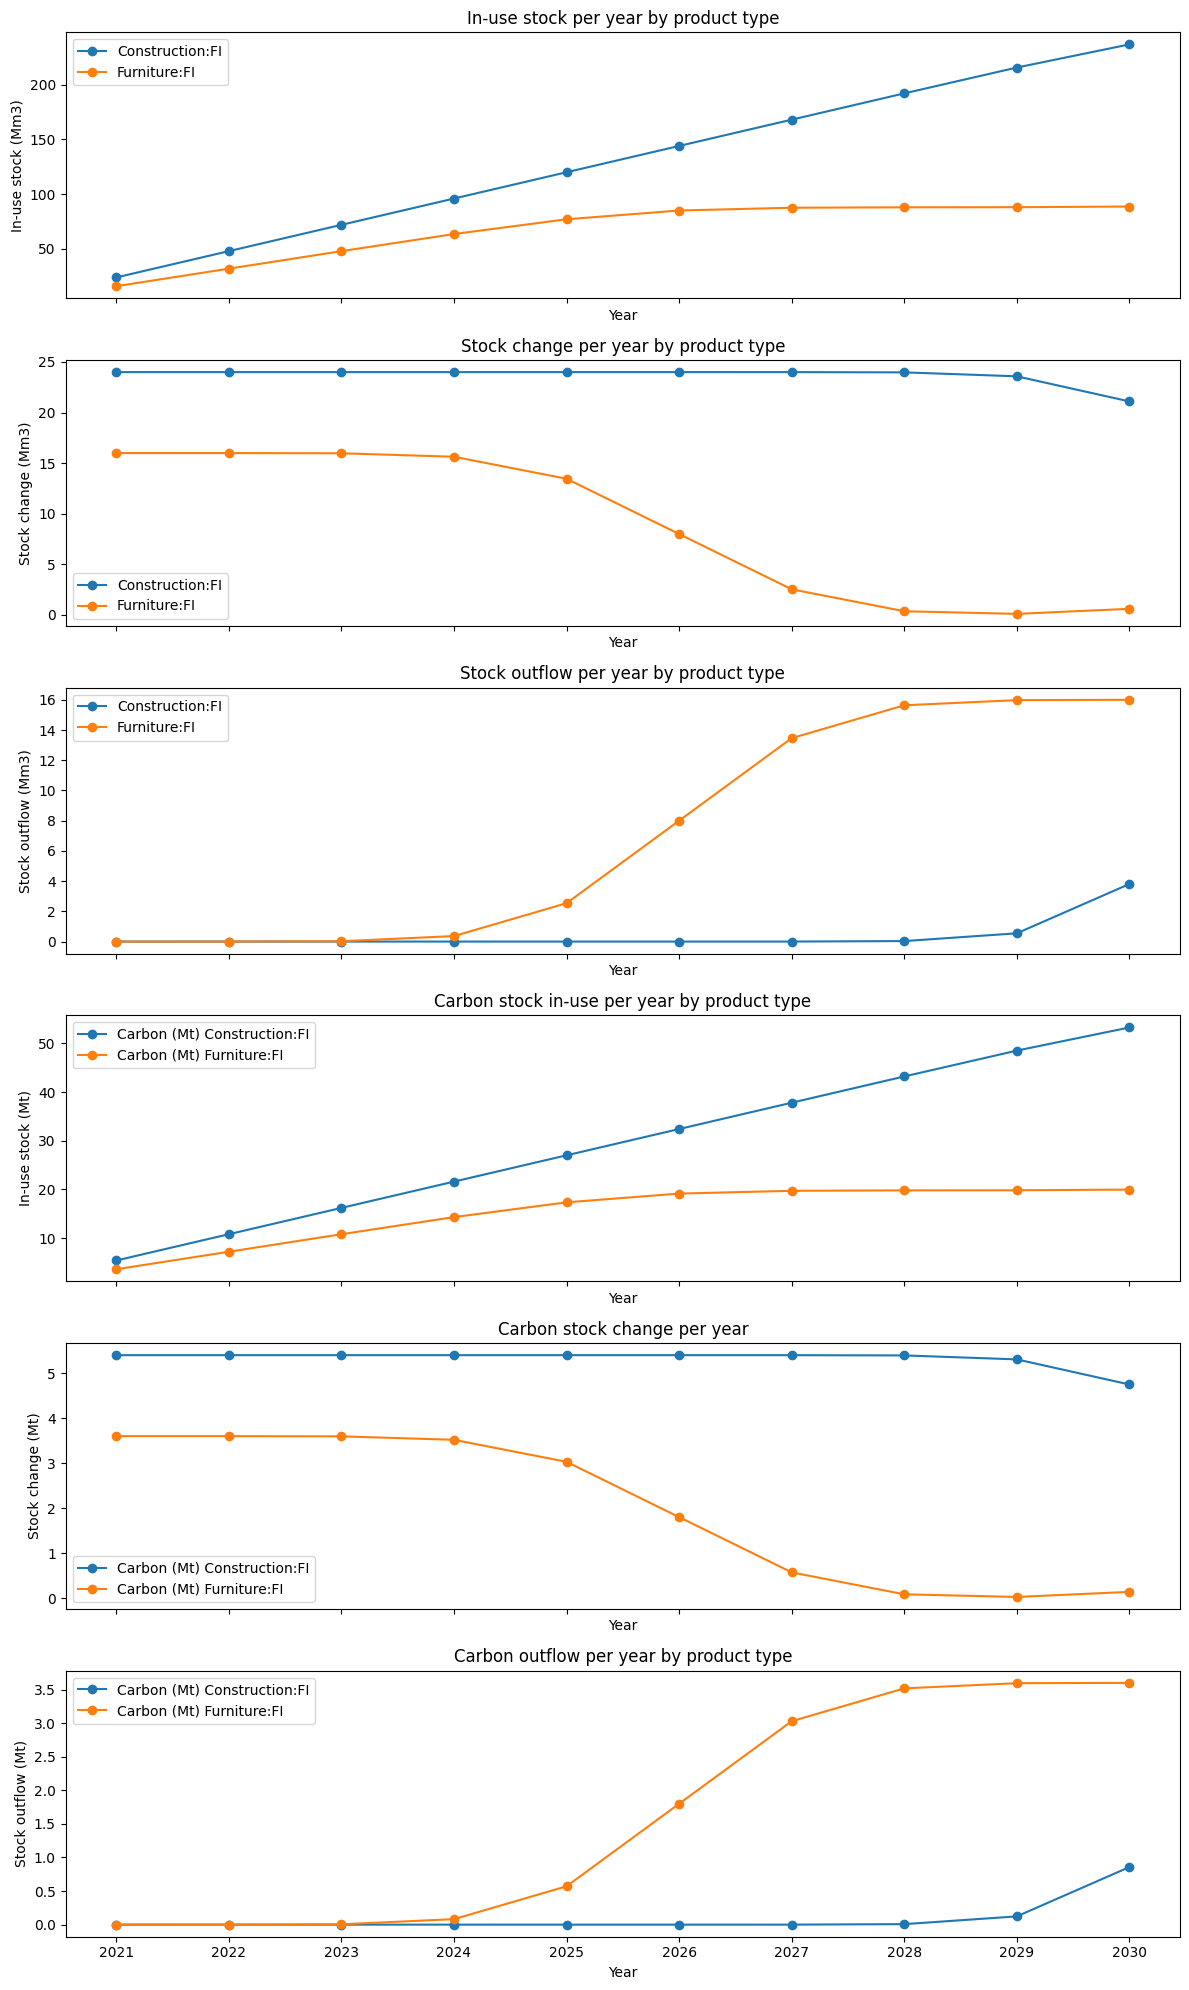

Building dynamic stock results (scenario 2/2):  50%|█████     | 1/2 [00:04<00:04,  4.43s/it]

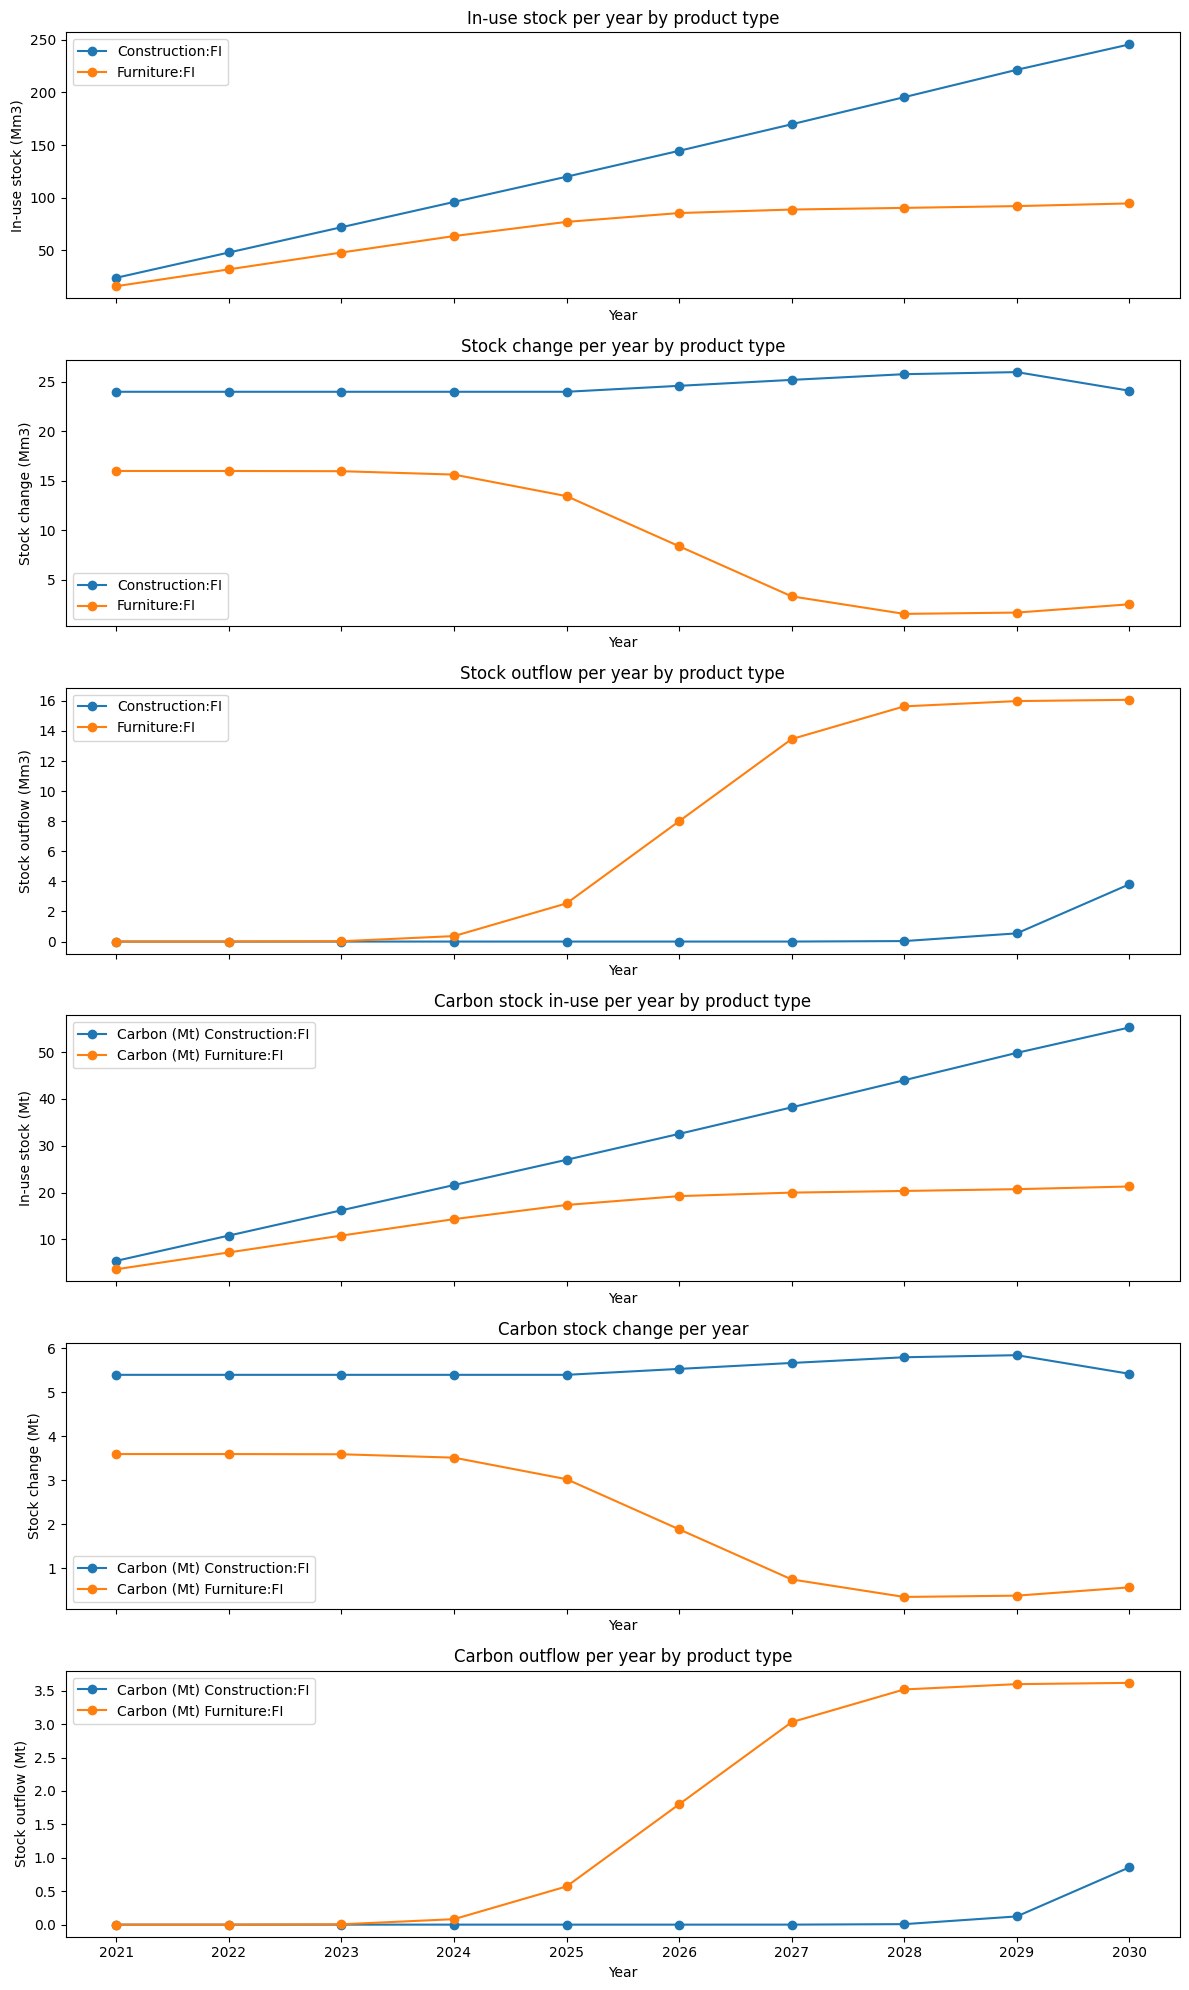

Building dynamic stock results (scenario 2/2): 100%|██████████| 2/2 [00:08<00:00,  4.17s/it]


In [5]:
# ***********************************************************************
# * Step 4: Build dynamic stock results for each Scenario and visualize *
# ***********************************************************************
progress_bar = tqdm(total=len(scenarios), desc="Building dynamic stock results")
sys.stderr.flush()
for scenario_index, scenario in enumerate(scenarios):
    progress_bar.set_description("Building dynamic stock results (scenario {}/{})".format(
        scenario_index + 1, len(scenarios)))

    flow_solver = scenario.flow_solver
    years = scenario.scenario_data.years
    scenario_output_path = scenario_name_to_output_path[scenario.name]

    # Full name of the baseline, e.g. "Solid wood equivalent"
    baseline_value_name = scenario.scenario_data.baseline_value_name
    baseline_unit_name = scenario.scenario_data.baseline_unit_name

    # Total number of indicators
    indicators = flow_solver.get_indicator_name_to_indicator()
    num_indicators = len(indicators.keys())

    # Baseline DSM
    stock_id_to_baseline_dsm = flow_solver.get_baseline_dynamic_stocks()
    stock_id_to_indicator_name_to_dsm = flow_solver.get_indicator_dynamic_stocks()

    if not len(stock_id_to_baseline_dsm.keys()):
        log("Scenario '{}': no dynamic stocks in the defined system".format(scenario.name))
        progress_bar.update(1)
        continue

    # Each baseline/indicator needs 3 plots
    # so total = baseline (3) + (number of indicators * 3)
    num_subplots = 3 + (num_indicators * 3)
    fig, axes = plt.subplots(num_subplots, 1, sharex='all', sharey='none', figsize=(12, 20))

    # Create an Excel writer for exporting data
    excel_filename = os.path.join(scenario_output_path, f"{scenario.name}_dynamic_stocks.xlsx")
    with pd.ExcelWriter(excel_filename, engine="xlsxwriter") as writer:
        all_stock_total_dfs = []
        all_stock_change_dfs = []
        all_stock_outflow_dfs = []
        for stock_id, baseline_dsm in stock_id_to_baseline_dsm.items():
            plot_index = 0

            # Truncate the stock ID to 20 characters (or any suitable length) to fit within the 31 character limit
            stock_id_for_filename = stock_id[:20]  # Truncate to the first 20 characters
            stock_id_for_filename = stock_id_for_filename.replace(":", "_")  # Replace ":" with "_"

            # ******************
            # * Baseline stock *
            # ******************
            baseline_stock_by_cohort = baseline_dsm.compute_s_c_inflow_driven()
            baseline_outflow_by_cohort = baseline_dsm.compute_o_c_from_s_c()
            baseline_stock_total = baseline_dsm.compute_stock_total()
            baseline_stock_change = baseline_dsm.compute_stock_change()
            baseline_stock_outflow = baseline_dsm.compute_outflow_total()

            # Export stock by cohort
            sheet_name = shorten_sheet_name(f'{stock_id_for_filename}_s_by_c_{baseline_value_name}')
            df_baseline_stock_by_cohort = pd.DataFrame(baseline_stock_by_cohort, columns=years, index=years)
            df_baseline_stock_by_cohort.to_excel(writer, sheet_name=sheet_name)

            # Export outflow by cohort
            sheet_name = shorten_sheet_name(f'{stock_id_for_filename}_o_by_c_{baseline_value_name}')
            df_baseline_outflow_by_cohort = pd.DataFrame(baseline_outflow_by_cohort, columns=years, index=years)
            df_baseline_outflow_by_cohort.to_excel(writer, sheet_name=sheet_name)

            # Export stock total
            df_baseline_stock_total = pd.DataFrame(baseline_stock_total, index=years)
            df_baseline_stock_total.reset_index(inplace=True)
            df_baseline_stock_total.columns = ["Year", "Stock total"]
            df_baseline_stock_total["Scenario"] = scenario.name
            df_baseline_stock_total["Stock ID"] = stock_id
            df_baseline_stock_total["Indicator"] = baseline_unit_name
            all_stock_total_dfs.append(df_baseline_stock_total)

            # Export stock change
            df_baseline_stock_change = pd.DataFrame(baseline_stock_change, index=years)
            df_baseline_stock_change.reset_index(inplace=True)
            df_baseline_stock_change.columns = ["Year", "Stock change"]
            df_baseline_stock_change["Scenario"] = scenario.name
            df_baseline_stock_change["Stock ID"] = stock_id
            df_baseline_stock_change["Indicator"] = baseline_unit_name
            all_stock_change_dfs.append(df_baseline_stock_change)

            # Export stock outflow total
            df_baseline_stock_outflow = pd.DataFrame(baseline_stock_outflow, index=years)
            df_baseline_stock_outflow.reset_index(inplace=True)
            df_baseline_stock_outflow.columns = ["Year", "Stock outflow total"]
            df_baseline_stock_outflow["Scenario"] = scenario.name
            df_baseline_stock_outflow["Stock ID"] = stock_id
            df_baseline_stock_outflow["Indicator"] = baseline_unit_name
            all_stock_outflow_dfs.append(df_baseline_stock_outflow)

            # Plot baseline stock total (in-use stocks)
            axes[plot_index + 0].plot(years, baseline_stock_total, marker='o', label="{}".format(stock_id))
            axes[plot_index + 0].set_ylabel("In-use stock ({})".format(baseline_unit_name))
            axes[plot_index + 0].set_title("In-use stock per year by product type")

            # Plot baseline stock change
            axes[plot_index + 1].plot(years, baseline_stock_change, marker='o', label=f'{stock_id}')
            axes[plot_index + 1].set_ylabel("Stock change ({})".format(baseline_unit_name))
            axes[plot_index + 1].set_title("Stock change per year by product type")

            # Plot baseline outflow by cohort
            axes[plot_index + 2].plot(years, baseline_stock_outflow, marker='o', label=f'{stock_id}')
            axes[plot_index + 2].set_ylabel("Stock outflow ({})".format(baseline_unit_name))
            axes[plot_index + 2].set_title("Stock outflow per year by product type")

            plot_index += 3
            for indicator_name, indicator_dsm in stock_id_to_indicator_name_to_dsm[stock_id].items():
                # **************
                # * Indicators *
                # **************
                indicator_unit = indicators[indicator_name].unit
                indicator_stock_by_cohort = indicator_dsm.compute_s_c_inflow_driven()
                indicator_outflow_by_cohort = indicator_dsm.compute_o_c_from_s_c()
                indicator_stock_total = indicator_dsm.compute_stock_total()
                indicator_stock_change = indicator_dsm.compute_stock_change()
                indicator_stock_outflow = indicator_dsm.compute_outflow_total()

                # Export indicator stock by cohort
                sheet_name = shorten_sheet_name(f"{stock_id_for_filename}_s_by_c_{indicator_name}")
                df_indicator_stock_by_cohort = pd.DataFrame(indicator_stock_by_cohort, columns=years, index=years)
                df_indicator_stock_by_cohort.to_excel(writer, sheet_name=sheet_name)

                # Export indicator outflow by cohort
                sheet_name = shorten_sheet_name(f'{stock_id_for_filename}_o_by_c_{indicator_name}')
                df_indicator_oc = pd.DataFrame(indicator_outflow_by_cohort, columns=years, index=years)
                df_indicator_oc.to_excel(writer, sheet_name=sheet_name)

                # Export indicator stock total
                df_indicator_stock_total = pd.DataFrame(indicator_stock_total, index=years)
                df_indicator_stock_total.reset_index(inplace=True)
                df_indicator_stock_total.columns = ["Year", "Stock total"]
                df_indicator_stock_total["Scenario"] = scenario.name
                df_indicator_stock_total["Stock ID"] = stock_id
                df_indicator_stock_total["Indicator"] = indicator_name
                all_stock_total_dfs.append(df_indicator_stock_total)

                # Export indicator stock change
                df_indicator_stock_change = pd.DataFrame(indicator_stock_change, index=years)
                df_indicator_stock_change.reset_index(inplace=True)
                df_indicator_stock_change.columns = ["Year", "Stock change"]
                df_indicator_stock_change["Scenario"] = scenario.name
                df_indicator_stock_change["Stock ID"] = stock_id
                df_indicator_stock_change["Indicator"] =indicator_name
                all_stock_change_dfs.append(df_indicator_stock_change)

                # Export indicator stock outflow total
                df_indicator_stock_outflow = pd.DataFrame(indicator_stock_outflow, index=years)
                df_indicator_stock_outflow.reset_index(inplace=True)
                df_indicator_stock_outflow.columns = ["Year", "Stock outflow total"]
                df_indicator_stock_outflow["Scenario"] = scenario.name
                df_indicator_stock_outflow["Stock ID"] = stock_id
                df_indicator_stock_outflow["Indicator"] =indicator_name
                all_stock_outflow_dfs.append(df_indicator_stock_outflow)

                # Plot indicator stock total (in-use stocks)
                axes[plot_index + 0].plot(years, indicator_stock_total, marker='o', label='{} ({}) {}'.format(
                    indicator_name, indicator_unit, stock_id))
                axes[plot_index + 0].set_ylabel("In-use stock ({})".format(indicator_unit))
                axes[plot_index + 0].set_title("{} stock in-use per year by product type".format(indicator_name))

                # Plot indicator stock change
                axes[plot_index + 1].plot(years, indicator_stock_change, marker='o', label="{} ({}) {}".format(
                    indicator_name, indicator_unit, stock_id))
                axes[plot_index + 1].set_ylabel("Stock change ({})".format(indicator_unit))
                axes[plot_index + 1].set_title("{} stock change per year".format(indicator_name))

                # Plot indicator outflow by cohort
                axes[plot_index + 2].plot(years, indicator_stock_outflow, marker='o', label="{} ({}) {}".format(
                    indicator_name, indicator_unit, stock_id
                ))
                axes[plot_index + 2].set_ylabel("Stock outflow ({})".format(indicator_unit))
                axes[plot_index + 2].set_title("{} outflow per year by product type".format(indicator_name))

                plot_index += 3

        if all_stock_total_dfs:
            combined_stock_total_df = pd.concat(all_stock_total_dfs, ignore_index=True)
            combined_sheet_name = "Total_stock"
            combined_stock_total_df.to_excel(writer, sheet_name=combined_sheet_name, index=False)

        if all_stock_change_dfs:
            combined_stock_change_df = pd.concat(all_stock_change_dfs, ignore_index=True)
            combined_sheet_name = "Total_stock_change"
            combined_stock_change_df.to_excel(writer, sheet_name=combined_sheet_name, index=False)

        if all_stock_outflow_dfs:
            all_stock_outflow_dfs = pd.concat(all_stock_outflow_dfs, ignore_index=True)
            combined_sheet_name = "Total_stock_outflow"
            all_stock_outflow_dfs.to_excel(writer, sheet_name=combined_sheet_name, index=False)

        # Set common properties to axes
        range_x_ticks = range(min(years), max(years) + 1)
        for axis in axes:
            axis.set_xlabel("Year")
            axis.title.set_size(12)
            axis.legend()

        # Adjust layout to prevent overlap
        plt.tight_layout()
        tick_gap = 1 if len(years) < 15 else 10
        plt.xticks(years[::tick_gap])

        # Save the figure as an SVG file
        filename = os.path.join(scenario_output_path, "{}_stock_plots_by_product.svg".format(scenario.name))
        plt.savefig(filename, format='svg')

        if model_params[ParameterName.ShowPlots]:
            plt.show()

    progress_bar.update(1)
progress_bar.refresh()
progress_bar.close()
sys.stderr.flush()


INFO: Calculating annual CO2 stock emissions / removals results...
INFO: Exporting annual CO2 emissions / removal (Mt) by stock results...
INFO: Exporting annual CO2 net emitter years (where removals < 0)...


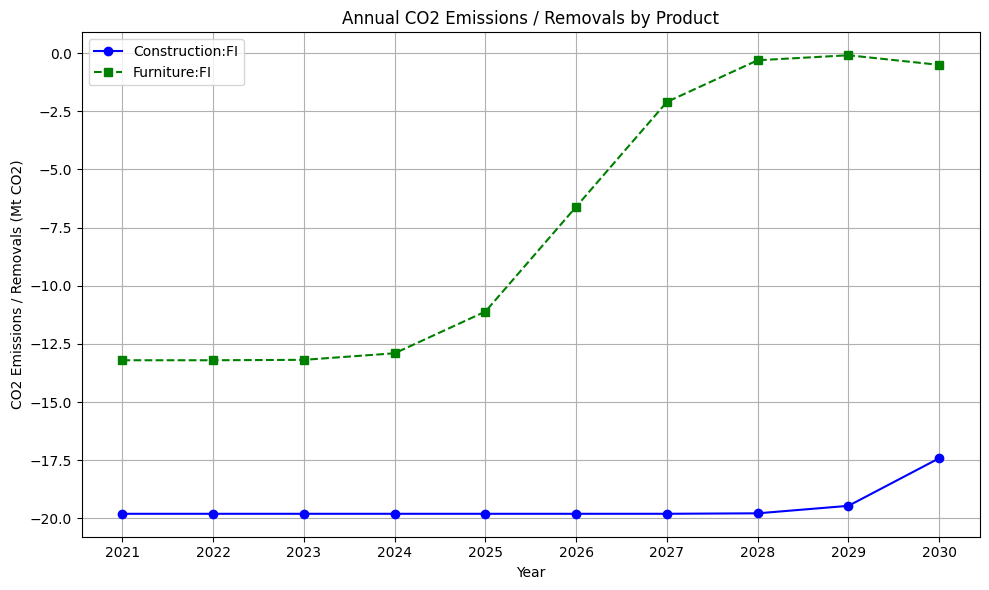


Steady-state periods for scenario 'Baseline':
  Construction:FI: 2023 to 2028 (6 years)
  Furniture:FI: No steady-state period detected.
INFO: Exporting annual CO2 emissions / removal (Mt) by stock results...
INFO: Exporting annual CO2 net emitter years (where removals < 0)...


C:\Python39\lib\site-packages\pandas\core\indexes\base.py:7834: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


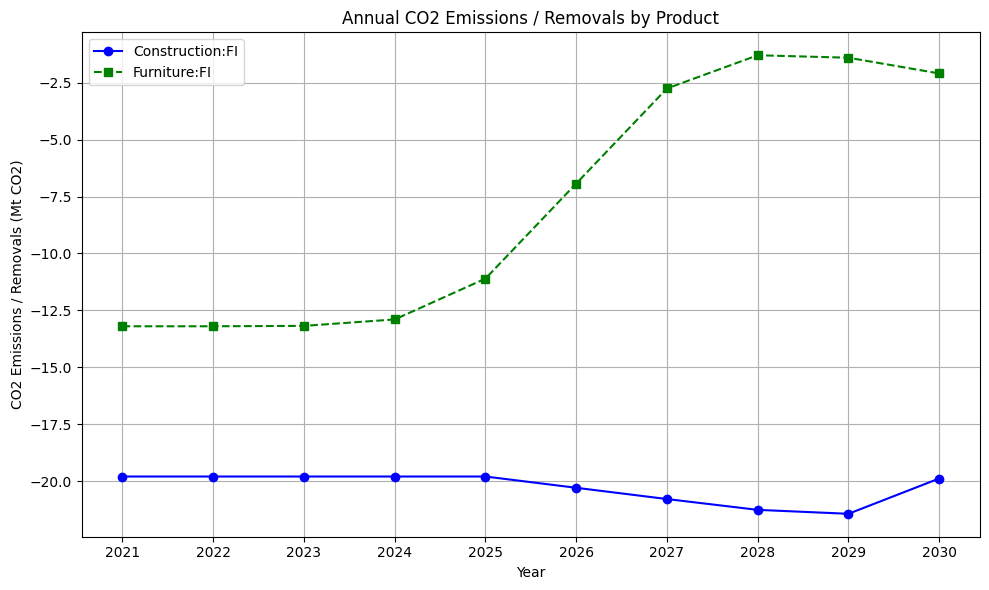


Steady-state periods for scenario 'Reduce sawmilling residues by 50%':
  Construction:FI: 2023 to 2028 (6 years)
  Furniture:FI: No steady-state period detected.

Performing statistical comparison against baseline...

Comparison: Reduce sawmilling residues by 50% vs Baseline
  Stock: Construction:FI
    - Mean (baseline): -19.52 Mt
    - Mean (Reduce sawmilling residues by 50%): -20.27 Mt
    - Std Dev (baseline): 0.71 Mt
    - Std Dev (Reduce sawmilling residues by 50%): 0.62 Mt
    - Net Balance Change: -7.42 Mt
    - p-value: 0.0341
  Stock: Furniture:FI
    - Mean (baseline): -7.32 Mt
    - Mean (Reduce sawmilling residues by 50%): -7.81 Mt
    - Std Dev (baseline): 5.70 Mt
    - Std Dev (Reduce sawmilling residues by 50%): 5.16 Mt
    - Net Balance Change: -4.88 Mt
    - p-value: 0.0330


C:\Python39\lib\site-packages\pandas\core\indexes\base.py:7834: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)



INFO: Generating automatic summary report...
INFO: Summary report saved to: C:\dev\PythonProjects\aiphoria\output\Baseline\summary_report.md


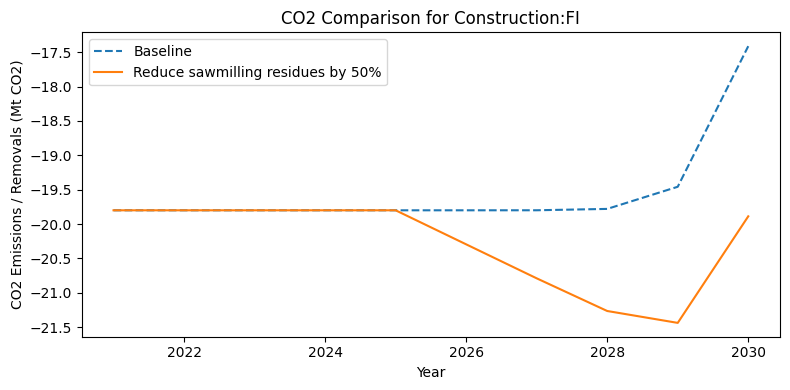

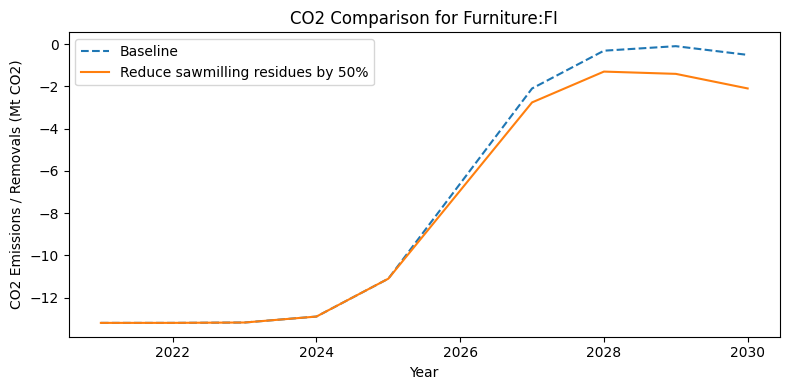

In [6]:
# *****************************************************
# * Step 5: Convert the carbon stocks to CO2 removals *
# *****************************************************
log("Calculating annual CO2 stock emissions / removals results...")

# Storage for comparison
all_scenario_results = {}
all_emitter_years = {}

show_steady_state_overlay = False  # Toggle to enable/disable overlay
steady_state_threshold_ratio = 0.05  # Relative threshold for stability
min_steady_state_years = 5  # Minimum consecutive years for valid steady state

for scenario in scenarios:
    scenario_output_path = scenario_name_to_output_path[scenario.name]
    flow_solver = scenario.flow_solver
    years = scenario.scenario_data.years
    year_start = scenario.scenario_data.start_year

    stock_id_to_indicator_name_to_dsm = flow_solver.get_indicator_dynamic_stocks()
    if not len(stock_id_to_indicator_name_to_dsm.keys()):
        log("Scenario '{}': no dynamic stocks in the defined system".format(scenario.name))
        continue

    results_co2_removals = pd.DataFrame({'Year': years})
    results_net_emitters = pd.DataFrame({'Year': years})
    conversion_factor_c_to_co2 = model_params[ParameterName.ConversionFactorCToCO2]

    # Define line styles, markers, and colors for differentiation
    line_styles = ['-', '--', '-.', ':']
    markers = ['o', 's', '^', 'D']
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

    target_indicator_name = "Carbon"
    plt.figure(figsize=(10, 6))

    scenario_results = {}
    steady_state_info = {}
    net_emitter_info = {}

    for index, (stock_id, indicator_name_to_dsm) in enumerate(stock_id_to_indicator_name_to_dsm.items()):
        if target_indicator_name not in indicator_name_to_dsm:
            continue

        dsm = indicator_name_to_dsm[target_indicator_name]
        total_inflows_carbon = dsm.i
        total_outflows_carbon = dsm.o
        annual_co2_removal = (total_inflows_carbon - total_outflows_carbon) * conversion_factor_c_to_co2
        results_co2_removals[stock_id] = annual_co2_removal
        scenario_results[stock_id] = annual_co2_removal

        # Detect steady-state years with rolling window approach
        threshold = steady_state_threshold_ratio * max(abs(annual_co2_removal))
        rolling_mean = pd.Series(annual_co2_removal).rolling(window=min_steady_state_years, center=True).mean()
        is_steady = abs(pd.Series(annual_co2_removal) - rolling_mean) < threshold

        # Extract consecutive steady years
        steady_years = []
        current_run = []
        for year, steady in zip(years, is_steady):
            if steady:
                current_run.append(year)
            else:
                if len(current_run) >= min_steady_state_years:
                    steady_years.extend(current_run)
                current_run = []
        if len(current_run) >= min_steady_state_years:
            steady_years.extend(current_run)

        steady_state_info[stock_id] = sorted(set(steady_years))

        # Detect net emitter years (negative removals)
        emitter_years = [year for year, value in zip(years, annual_co2_removal) if value < 0]
        results_net_emitters[stock_id] = ["Emitter" if value < 0 else "" for value in annual_co2_removal]
        net_emitter_info[stock_id] = emitter_years

        # Plot CO2 removals with steady state overlay
        line_style = line_styles[index % len(line_styles)]
        marker = markers[index % len(markers)]
        color = colors[index % len(colors)]
        plt.plot(years, annual_co2_removal, marker=marker, linestyle=line_style, color=color,
                 label=f'{stock_id}')
        if show_steady_state_overlay and steady_years:
            plt.axvspan(steady_years[0], steady_years[-1], color=color, alpha=0.1)

    all_scenario_results[scenario.name] = scenario_results
    all_emitter_years[scenario.name] = net_emitter_info

    plt.xlabel('Year')
    plt.ylabel('CO2 Emissions / Removals (Mt CO2)')
    plt.title('Annual CO2 Emissions / Removals by Product')
    plt.grid(True)
    tick_gap = 1 if len(years) < 15 else 10
    plt.xticks(years[::tick_gap])
    plt.legend()
    plt.tight_layout()

    # Export CO2 removal data to CSV
    log("Exporting annual CO2 emissions / removal (Mt) by stock results...")
    filename = os.path.join(scenario_output_path, f"{scenario.name}_annual_co2_removal_by_stock.csv")
    results_co2_removals.to_csv(path_or_buf=filename, index=False, mode="w")

    # Export net emitter flag table
    log("Exporting annual CO2 net emitter years (where removals < 0)...")
    filename = os.path.join(scenario_output_path, f"{scenario.name}_annual_net_emitter_flags.csv")
    results_net_emitters.to_csv(path_or_buf=filename, index=False, mode="w")

    # Export CO2 removal plot as SVG
    filename = os.path.join(scenario_output_path, f"{scenario.name}_annual_co2_removal_by_product.svg")
    plt.savefig(filename, format='svg')

    if model_params[ParameterName.ShowPlots]:
        plt.show()

    # Print and export steady-state info
    print(f"\nSteady-state periods for scenario '{scenario.name}':")
    for stock_id, years_list in steady_state_info.items():
        if years_list:
            print(f"  {stock_id}: {years_list[0]} to {years_list[-1]} ({len(years_list)} years)")
        else:
            print(f"  {stock_id}: No steady-state period detected.")

    steady_state_df = pd.DataFrame([
        {'Stock': stock_id, 'StartYear': years_list[0] if years_list else None,
         'EndYear': years_list[-1] if years_list else None, 'DurationYears': len(years_list)}
        for stock_id, years_list in steady_state_info.items()
    ])
    filename = os.path.join(scenario_output_path, f"{scenario.name}_steady_state_periods.csv")
    steady_state_df.to_csv(filename, index=False)

# Statistical comparison against baseline
print("\nPerforming statistical comparison against baseline...")
baseline_name = scenarios[0].name
if baseline_name in all_scenario_results:
    baseline_results = all_scenario_results[baseline_name]
    for scenario in scenarios[1:]:
        scenario_name = scenario.name
        scenario_results = all_scenario_results[scenario_name]
        print(f"\nComparison: {scenario_name} vs {baseline_name}")

        for stock_id in baseline_results:
            if stock_id not in scenario_results:
                continue

            baseline_values = baseline_results[stock_id]
            scenario_values = scenario_results[stock_id]

            if not np.allclose(baseline_values, scenario_values, atol=1e-3):
                t_stat, p_value = stats.ttest_rel(baseline_values, scenario_values)
                print(f"  Stock: {stock_id}")
                print(f"    - Mean (baseline): {np.mean(baseline_values):.2f} Mt")
                print(f"    - Mean ({scenario_name}): {np.mean(scenario_values):.2f} Mt")
                print(f"    - Std Dev (baseline): {np.std(baseline_values):.2f} Mt")
                print(f"    - Std Dev ({scenario_name}): {np.std(scenario_values):.2f} Mt")
                print(f"    - Net Balance Change: {sum(scenario_values) - sum(baseline_values):.2f} Mt")
                print(f"    - p-value: {p_value:.4f}")

                # Save plot for changed stocks
                plt.figure(figsize=(8, 4))
                plt.plot(years, baseline_values, label=f"{baseline_name}", linestyle="--")
                plt.plot(years, scenario_values, label=f"{scenario_name}", linestyle="-")
                plt.title(f"CO2 Comparison for {stock_id}")
                plt.xlabel("Year")
                plt.ylabel("CO2 Emissions / Removals (Mt CO2)")
                plt.legend()
                plt.tight_layout()
                comp_filename = os.path.join(scenario_name_to_output_path[scenario_name], f"comparison_{stock_id}.svg")
                plt.savefig(comp_filename, format="svg")

    # Export automatic markdown summary report
    log("")
    log("Generating automatic summary report...")
    report_lines = []
    report_lines.append("# CO₂ Removal Analysis Summary\n")
    for scenario_name, scenario_data in all_scenario_results.items():
        report_lines.append(f"## Scenario: {scenario_name}\n")
        for stock_id, removals in scenario_data.items():
            net_balance = np.sum(removals)
            mean_val = np.mean(removals)
            std_val = np.std(removals)
            emit_years = all_emitter_years[scenario_name].get(stock_id, [])
            report_lines.append(f"- **{stock_id}**: Net balance = {net_balance:.2f} Mt, Mean = {mean_val:.2f} Mt, Std = {std_val:.2f} Mt\n")
            if emit_years:
                report_lines.append(f"    - Emits CO₂ in years: {', '.join(map(str, emit_years))}\n")
    report_text = "\n".join(report_lines)
    summary_filename = os.path.join(scenario_name_to_output_path[baseline_name], "summary_report.md")
    with open(summary_filename, "w", encoding="utf-8") as f:
        f.write(report_text)
    log(f"Summary report saved to: {summary_filename}")


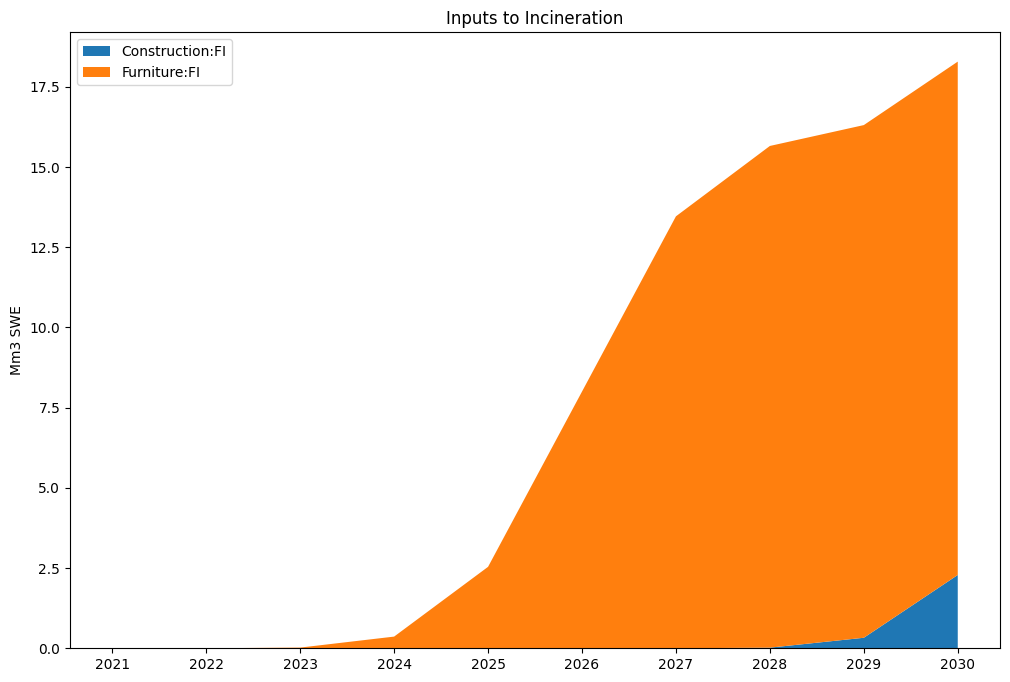

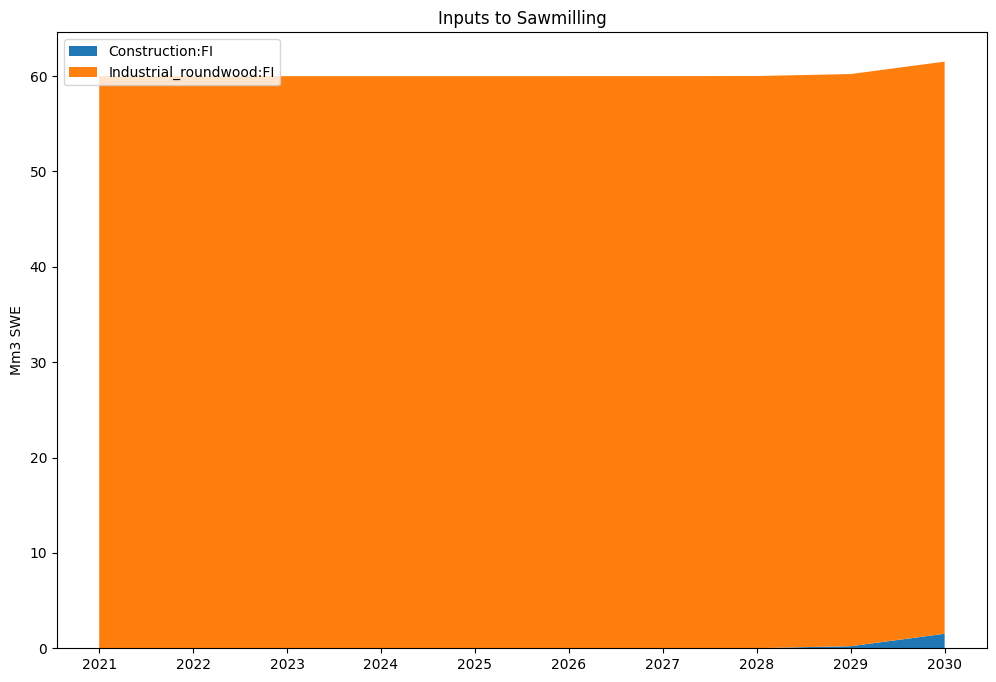

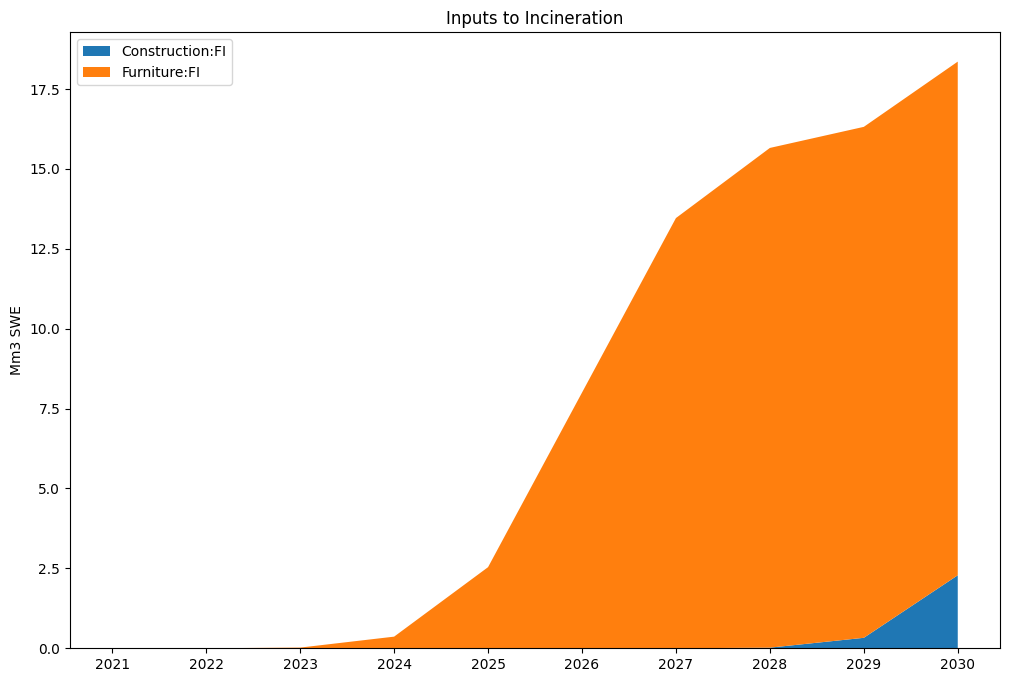

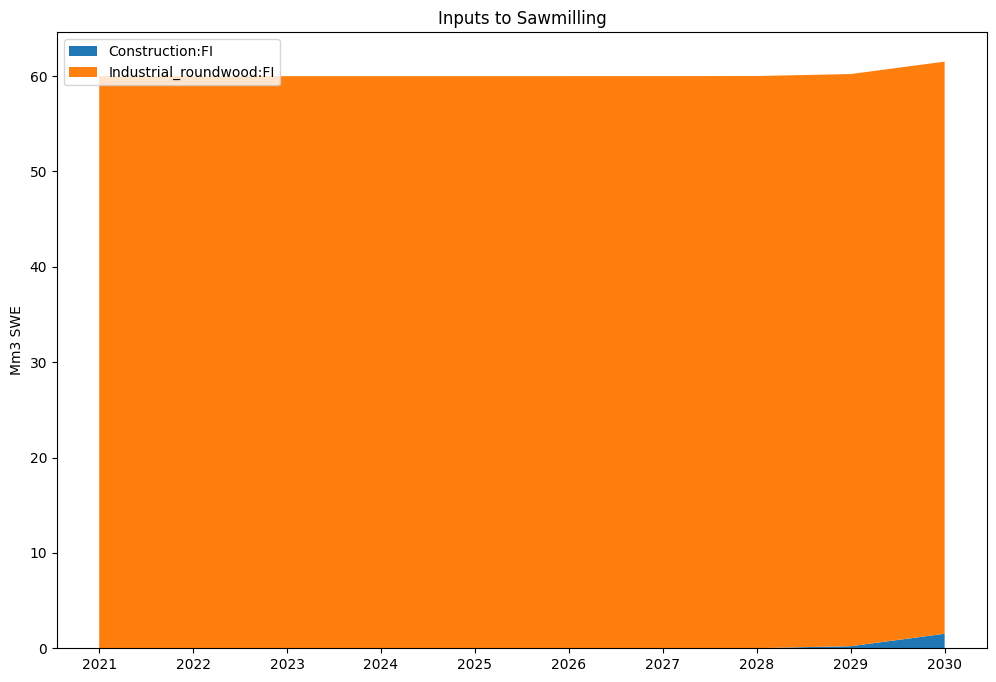

In [7]:
# ************************************************************
# * Step 6: Visualize inflows per year to selected processes *
# ************************************************************

# This is only done when there is multiple years
# Visualize inflows per year to processes
visualize_inflows_to_process_ids = model_params[ParameterName.VisualizeInflowsToProcesses]
for scenario in scenarios:
    scenario_output_path = scenario_name_to_output_path[scenario.name]
    flow_solver = scenario.flow_solver
    years = scenario.scenario_data.years

    # Dictionary: Process ID to process
    unique_processes = flow_solver.get_unique_processes()
    for process_id in visualize_inflows_to_process_ids:
        process = flow_solver.get_process(process_id, min(years))
        flow_id_to_source_process_id = {}
        source_process_names = []

        # Find all source processes of all incoming flows to this process in all years
        # This is needed to create stable set of process names so that the relative
        # position of the processes stay the same in stacked chart between the years
        source_process_ids = set()
        for year in years:
            inflows = flow_solver.get_process_flows(process_id, year)["Inflows"]
            unique_flow_ids = set()
            for flow in inflows:
                unique_flow_ids.add(flow.id)
                flow_id_to_source_process_id[flow.id] = flow.source_process_id

            # Find source process ID of each incoming flow and add
            # to list of unique source process IDs if not already there
            unique_flow_ids = list(unique_flow_ids)
            for flow_id in unique_flow_ids:
                source_process_ids.add(flow_id_to_source_process_id[flow_id])

        # Now source_process_ids-list contains list of all the possible process IDs
        # that have flows incoming to process_id. This list is needed to keep the
        # incoming process IDs the same every year because aiphoria allows the connections
        # between the flows to change between the years.
        source_process_ids = list(source_process_ids)

        # Create 2D array with shape of (number of source process IDs, number of years)
        # and fill with the value of the inflow from source process for each year
        df_inflows_to_process = pd.DataFrame(columns=['Year', 'Source Process ID', 'Value ({})'.format(
            model_params[ParameterName.BaselineUnitName])])
        source_process_by_flow_values = np.zeros((len(source_process_ids), len(years)))
        for year_index, year in enumerate(years):
            inflows = flow_solver.get_process_flows(process_id, year)["Inflows"]
            for flow in inflows:
                source_process_id_index = source_process_ids.index(flow.source_process_id)
                source_process_by_flow_values[source_process_id_index, year_index] = flow.evaluated_value
                df_inflows_to_process.loc[len(df_inflows_to_process)] = [year, flow.source_process_id,
                                                                         flow.evaluated_value]
        df_inflows_to_process = df_inflows_to_process.round(5)

        # Export inflows to process to CSV file
        # NOTE: Replace character ':' in Process ID to underscore because
        # Windows system are not able to handle that character in filename
        process_id_for_filename = process_id.replace(":", "_")
        filename = os.path.join(scenario_output_path,
                                "{}_inflows_to_{}.csv".format(scenario.name, process_id_for_filename))
        df_inflows_to_process.to_csv(path_or_buf=filename, index=False, mode="w")

        # Initialize the figure and axes for the stacked area chart
        fig, ax = plt.subplots(figsize=(12, 8))
        ax.stackplot(years, source_process_by_flow_values, labels=list(source_process_ids))
        ax.set_ylabel("Mm3 SWE")
        ax.set_title("Inputs to {}".format(process.name))
        ax.legend(loc='upper left')
        tick_gap = 1 if len(years) < 15 else 10
        plt.xticks(years[::tick_gap])

        # Save the figure as an SVG file
        filename = os.path.join(scenario_output_path,
                                "{}_inflows_to_{}.svg".format(scenario.name, process_id_for_filename))
        plt.savefig(filename, format='svg')

        if model_params[ParameterName.ShowPlots]:
            plt.show()


In [8]:
# ***********************************************************
# * Step 7: Visualize the scenario results as Sankey graphs *
# ***********************************************************

# Virtual process graph label overrides
# TODO: Move to settings file
virtual_process_graph_labels = dict()
virtual_process_graph_labels["VP_P2:EU"] = "Unreported flow from P2"
virtual_process_graph_labels["VP_P3:EU"] = "Unreported flow from P3"

# Virtual Process and virtual Flow colors
visualizer_params = {
    # User can hide processes in Sankey graph that have total inflows less than this value
    # This value cannot be changed now in the Sankey graph
    "small_node_threshold": 5,

    # Dictionary to define labels for virtual flows
    # If dictionary contains label for the virtual process then that is used,
    # otherwise the virtual process ID is used
    "virtual_process_graph_labels": virtual_process_graph_labels,

    # Dictionary to define color of process by the process transformation stage name
    # All must be provided as a RGB hex string, prefixed by character '#'
    # Usage example: { "Source": "#707070" }
    "process_transformation_stage_colors": color_definitions,

    # How transparent flows are (0.0 = invisible, 1.0 = fully opaque)
    "flow_alpha": 0.75,

    # Color for virtual process
    "virtual_process_color": "rgba(0.3, 0.3, 0.3, 0.6)",

    # Color for virtual flows
    "virtual_flow_color": "#808080",
}

# NOTE: Each scenario is now in separate files
if model_params[ParameterName.CreateSankeyCharts]:
    log("Creating Sankey charts for scenarios...")
    visualizer = DataVisualizer()
    visualizer.build_and_show(scenarios, visualizer_params, model_params)

time_total_in_secs = time.perf_counter() - time_total_in_secs
log("Finished in {:.2f}s".format(time_total_in_secs))

INFO: Creating Sankey charts for scenarios...
INFO: Finished in 15.30s
